In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from IPython.display import display
%matplotlib inline 
np.random.seed(42)
import os

os.chdir("C:/Users/ankit/ML_datasets/housing")
housing = pd.read_csv("train.csv")
housing.head(5)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [2]:
# We can use ID column as the index
housing = housing.set_index('Id')

In [3]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1460 entries, 1 to 1460
Data columns (total 80 columns):
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 non-null int64
YearBuilt        1460 non-null int64
YearRemodAdd     1460 non-null int64
RoofStyle        1460 non-null object
RoofMatl         1460 non-null object
Exterior1st      1460 non-null object
Exterior2nd      1460 non-

In [4]:
# Verify correct number of rows and columns are imported
assert housing.shape == (1460, 80)

Which variables are numerical and categorical? Are there any columns that can be deleted?

In [5]:
# Making sure the dtype of each column is correct.
# Noticed that there is one column MSSubClass in particular that should be categorical but will load in pandas as numeric. 
housing['MSSubClass'] = housing['MSSubClass'].astype('object')

Plotting numeric columns

In [6]:
numeric_columns = housing.select_dtypes(exclude=['object']).columns

C:\Users\ankit\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared
  after removing the cwd from sys.path.
C:\Users\ankit\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


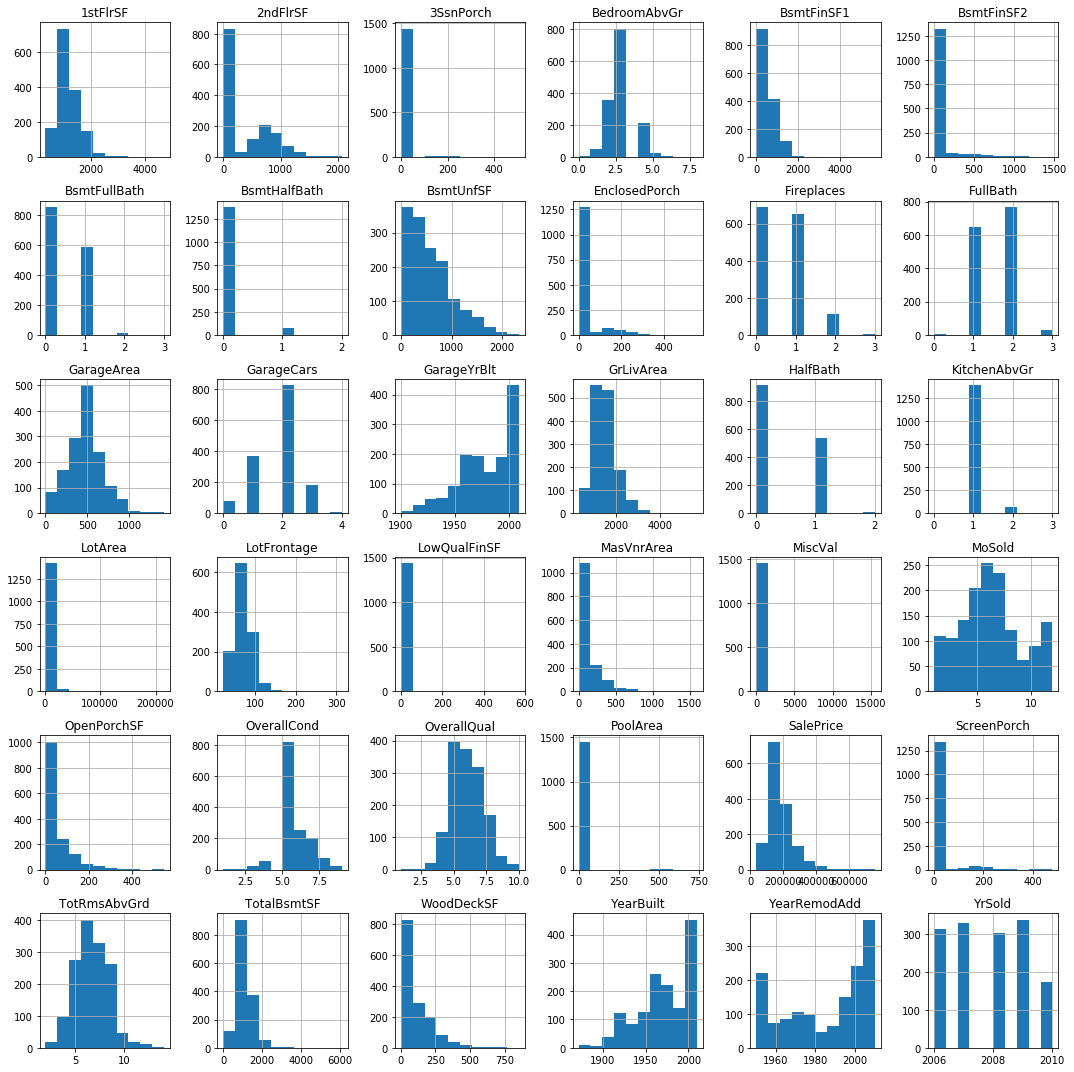

In [7]:
# Plotting the numerical columns
fig = plt.figure(figsize = (15,15))
ax = fig.gca()
housing[numeric_columns].hist(ax=ax)
fig.tight_layout()
fig.show()

fig.savefig('numeric_hist.png')

There are different types of features:
Area based, Time based, facilities, Condition

Most of the variables that deal with the actual physical space of the apartment are postively skewed - which makes sense, as people tend to live in smaller homes/apartments apart from the extremely wealthy.

Sale Price also has a similar postively skewed distribution so I hypothesize that the variables dealing with the acutal dimensions of the apartment have a large impact on Sale Price. So now I plot the Numeric Columns Against SalePrice using scatter plots.

C:\Users\ankit\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


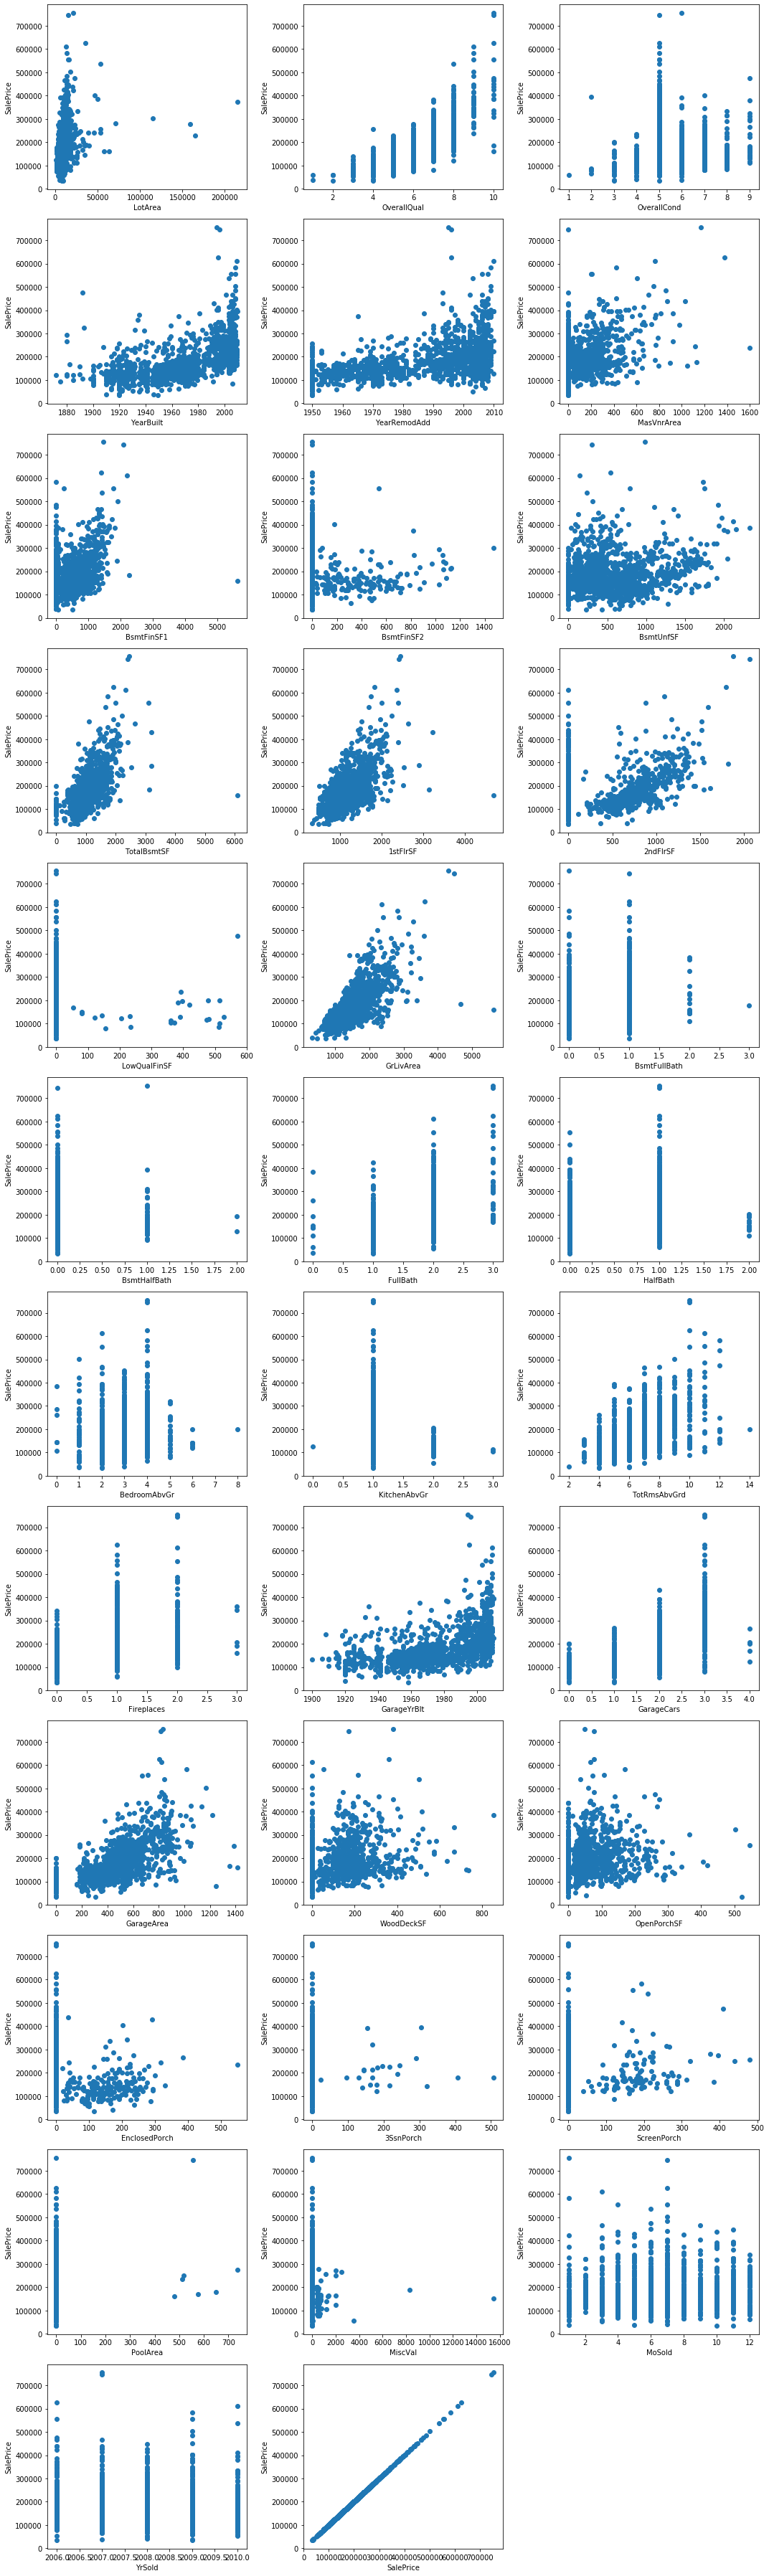

In [8]:
fig = plt.figure(figsize=(15,50))
for i, col in enumerate(numeric_columns[1:]):
    fig.add_subplot(12,3,1+i) # 3 integer arguments—no of rows, no of columns, and the index of the plot to be created
    plt.scatter(housing[col], housing['SalePrice'])
    plt.xlabel(col)
    plt.ylabel('SalePrice')
fig.tight_layout() # automatically adjusts subplot params so that the subplots fit in to the figure area.
fig.show()

fig.savefig('numeric_scatter.png')

There looks to be a lot of null values in the data (looking at ther 'vertical bars' at 0 along the x-axis) - will need to deal with them before analysis.

Many features do not have a strong relationship with Sale Price, such as 'Year Sold'.

Now plotting categorical features against SalePrice.

C:\Users\ankit\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


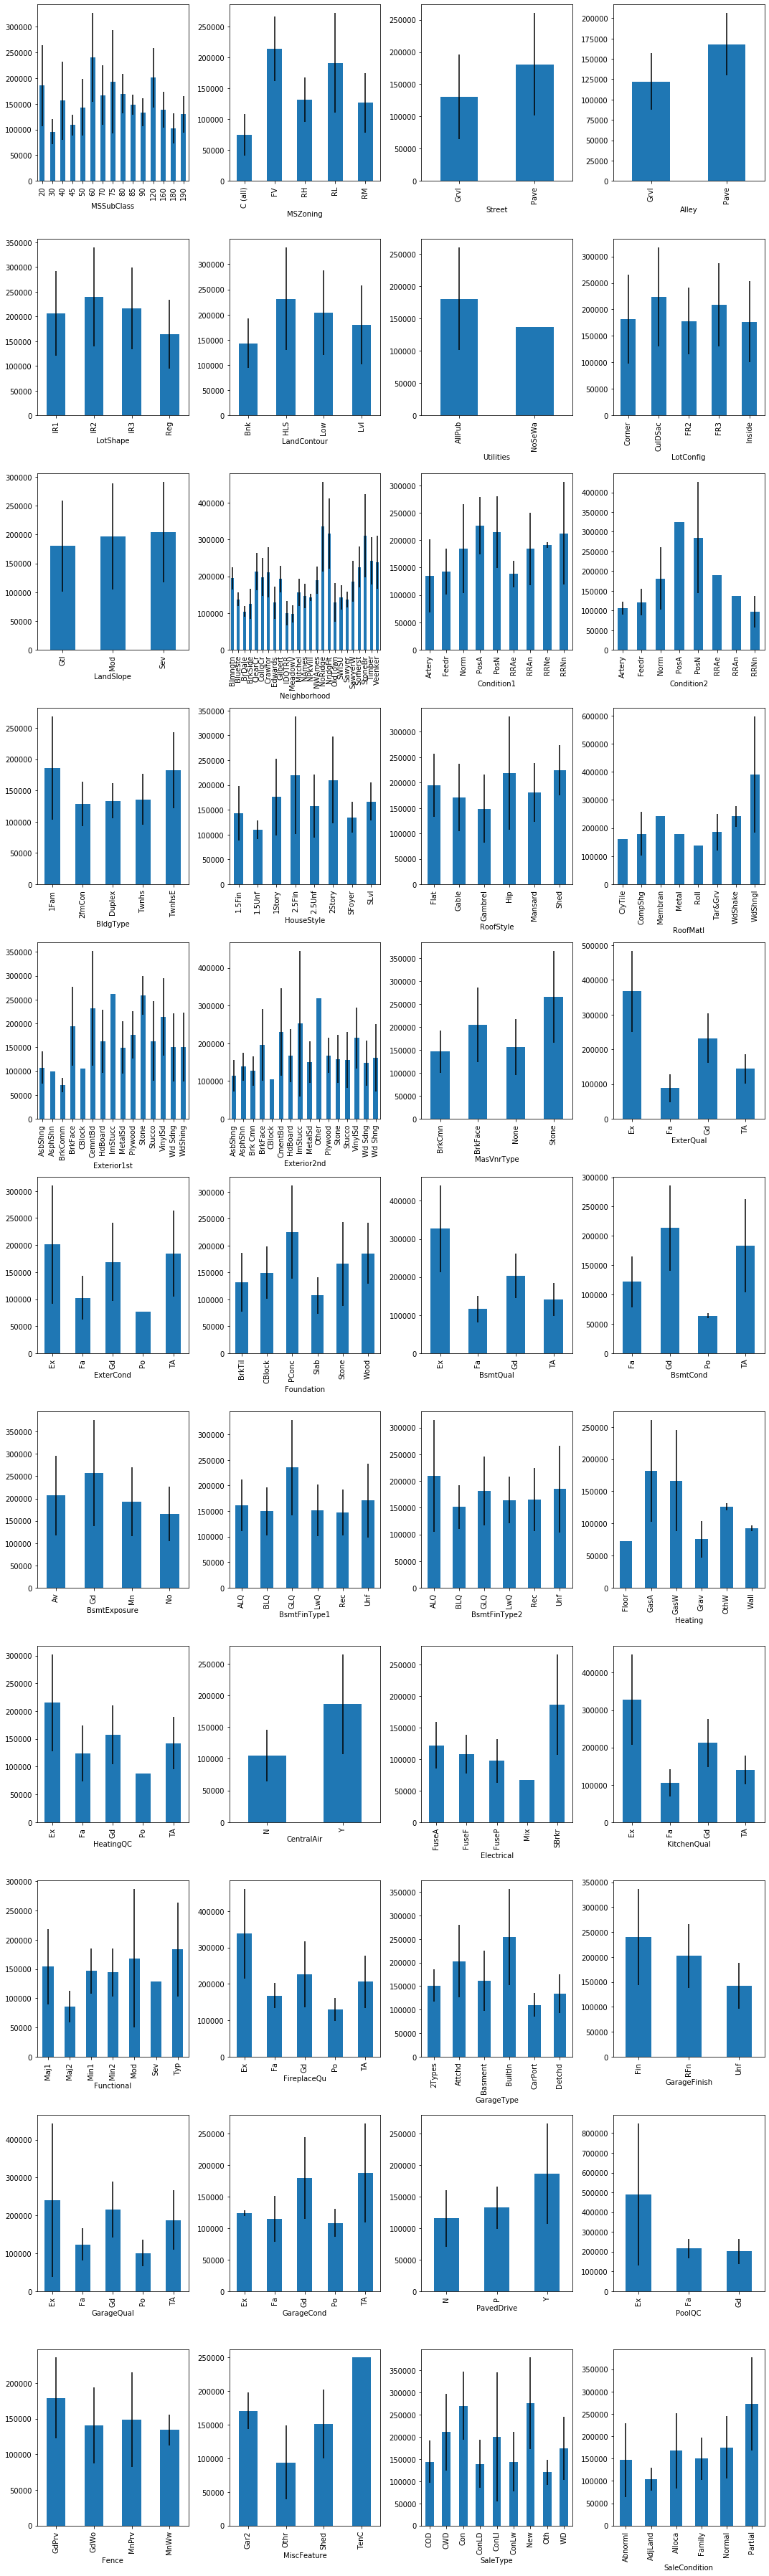

In [12]:
categorical_columns = housing.select_dtypes(['object']).columns
# Plotting error bars https://www.youtube.com/watch?v=otqk4eIDMcg
fig = plt.figure(figsize=(15,50))
for i, col in enumerate(categorical_columns):
    fig.add_subplot(11,4,1+i)
    housing.groupby(col).mean()['SalePrice'].plot.bar(yerr = housing.groupby(col).std()) # Vertical error bars are supplied to yerr
fig.tight_layout()
fig.show()

fig.savefig('categorical_bar.png')

Only some of the categorical columns seem to have a strong impact on Sale Price. Having a paved street, excellent 'BsmtQual' and 'ExterQual', and Central Air seem like they have a correlation with higher Sale Price. (See: https://www.biologyforlife.com/interpreting-error-bars.html)

Now removing outliers. Supply a definition of what an outlier is by your criteria. Does Tukey's method make sense with 1.5 times the interquartile range, or should that range be increased or decreased? e.g. Tukey's method for defining outliers (1.5 IQR) cut out too much of the data, so I used 3 IQR instead.

In [15]:
housing['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

In [16]:
IQR = housing['SalePrice'].quantile(.75) - housing['SalePrice'].quantile(.25)

IQR

84025.0

In [17]:
upper_bound = housing['SalePrice'].quantile(.75) + 3 * IQR
upper_bound_mask = housing.SalePrice > upper_bound
lower_bound = housing['SalePrice'].quantile(.25) - 3 * IQR
lower_bound_mask = housing.SalePrice < upper_bound

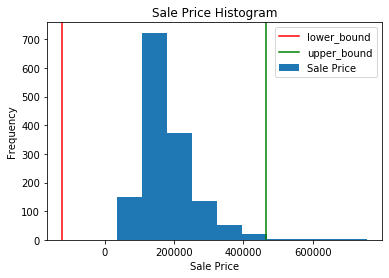

In [18]:
plt.hist(housing['SalePrice'], label='Sale Price')
plt.xlabel("Sale Price")
plt.ylabel("Frequency")
plt.title("Sale Price Histogram")
plt.axvline(lower_bound, color='r', label='lower_bound')
plt.axvline(upper_bound, color='g', label='upper_bound')
plt.legend()
plt.show()

In [19]:
housing_no_outliers = housing[(housing.SalePrice < upper_bound) | (housing.SalePrice > lower_bound)]

Fill missing data. Some columns that are appearing as null might legitimately be known (ie: "na"). Double check the data description for proper value representation. A feature might actually be better represented by "not available" or "na" rather than NULL or NaN. There's a difference between NULL (unknown), and "NA" (not available). It might mean the difference between "there isn't a garage" and "there is no garage data".

In [20]:
housing_no_outliers.isnull().sum().sort_values(ascending=False)

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
FireplaceQu       690
                 ... 
CentralAir          0
SaleCondition       0
Heating             0
TotalBsmtSF         0
MSSubClass          0
Length: 80, dtype: int64

In [21]:
housing_nan_columns = []

for column in housing_no_outliers:
    if housing_no_outliers[column].isnull().sum() > 0:
        housing_nan_columns.append(column)

housing_nan_columns

['LotFrontage',
 'Alley',
 'MasVnrType',
 'MasVnrArea',
 'BsmtQual',
 'BsmtCond',
 'BsmtExposure',
 'BsmtFinType1',
 'BsmtFinType2',
 'Electrical',
 'FireplaceQu',
 'GarageType',
 'GarageYrBlt',
 'GarageFinish',
 'GarageQual',
 'GarageCond',
 'PoolQC',
 'Fence',
 'MiscFeature']

In [22]:
housing_no_outliers['LotFrontage'] = housing_no_outliers['LotFrontage'].fillna(0)

housing_no_outliers['Alley'] = housing_no_outliers['Alley'].fillna('no_alley')

housing_no_outliers['MasVnrType'] = housing_no_outliers['MasVnrType'].fillna('no_veneer')

housing_no_outliers['MasVnrArea'] = housing_no_outliers['MasVnrArea'].fillna(0)

housing_no_outliers['BsmtQual'] = housing_no_outliers['BsmtQual'].fillna('no_basement')

housing_no_outliers['BsmtCond'] = housing_no_outliers['BsmtCond'].fillna('no_basement')

housing_no_outliers['BsmtExposure'] = housing_no_outliers['BsmtExposure'].fillna('no_basement')

housing_no_outliers['BsmtFinType1'] = housing_no_outliers['BsmtFinType1'].fillna('no_basement')

housing_no_outliers['BsmtFinType2'] = housing_no_outliers['BsmtFinType2'].fillna('no_basement')

housing_no_outliers['Electrical'] = housing_no_outliers['Electrical'].fillna('no_electricity')

housing_no_outliers['FireplaceQu'] = housing_no_outliers['FireplaceQu'].fillna('no_fireplace')

housing_no_outliers['GarageType'] = housing_no_outliers['GarageType'].fillna('no_garage')

housing_no_outliers['GarageYrBlt'] = housing_no_outliers['GarageYrBlt'].fillna(np.nanmedian(housing_no_outliers['GarageYrBlt']))

housing_no_outliers['GarageFinish'] = housing_no_outliers['GarageFinish'].fillna('no_garage')

housing_no_outliers['GarageQual'] = housing_no_outliers['GarageQual'].fillna('no_garage')

housing_no_outliers['GarageCond'] = housing_no_outliers['GarageCond'].fillna('no_garage')

housing_no_outliers['PoolQC'] = housing_no_outliers['PoolQC'].fillna('no_pool')

housing_no_outliers['Fence'] = housing_no_outliers['Fence'].fillna('no_fence')

housing_no_outliers['MiscFeature'] = housing_no_outliers['MiscFeature'].fillna('no_misc_features')

In [23]:
housing_no_outliers.isnull().sum().sum()

0